In [1]:
import sys
sys.path.append("/global/homes/a/arosado/")
from prepare_data import prepare_LRGmock_data, maps_dr9, hpixsum
from astropy.table import Table, vstack

import os
import utils as ut
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [ ]:
%%time
norm_method = 'mean'
mock_main = ut.get_mock(contaminated=False, selection_fn=None, nside=256, norm_method=norm_method,
                        tracer='LRG', ph=0, main=1, nz=0, Y5=1, sv3=0)
mock_raw = ut.get_mock(contaminated=False, selection_fn=None, nside=256, norm_method=norm_method,
                       tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

In [ ]:
dndz_main = Table()
dndz_raw = Table()
bins = 1000

n_raw, z_raw = np.histogram(mock_raw['Z'], bins=bins)
bc_raw = (z_raw[:-1] + z_raw[1:])/2.
dndz_raw.add_column(bc_raw, name='zmid')
dndz_raw.add_column(n_raw, name='n(z)')

n_main, z_main = np.histogram(mock_main['Z'], bins=bins)
bc_main = (z_main[:-1] + z_main[1:])/2.
dndz_main.add_column(bc_main, name='zmid')
dndz_main.add_column(n_main, name='n(z)')

plt.plot(dndz_raw['zmid'], dndz_raw['n(z)'], label='dndz: main=0,Y5=1')
plt.plot(dndz_main['zmid'], dndz_main['n(z)'], label='dndz: main=1,Y5=1')
plt.legend()
plt.show()

In [5]:
dndz_main.write('LRG_nz_main.fits', format='fits')
dndz_raw.write('LRG_nz_raw.fits', format='fits')

In [6]:
# read files
raw = Table.read('LRG_nz_raw.fits')
main = Table.read('LRG_nz_main.fits')

In [9]:
f_main = interpolate.interp1d(main['zmid'], main['n(z)'], fill_value='extrapolate')
f_raw = interpolate.interp1d(raw['zmid'], raw['n(z)'], fill_value='extrapolate')

In [10]:
n_main = f_main(mock_main['Z'])
n_raw = f_raw(mock_raw['Z'])

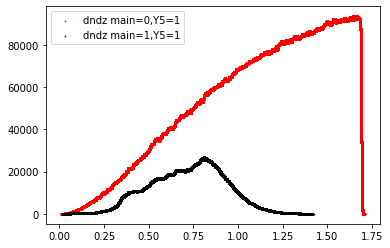

In [14]:
# do not rerun this cell, cell takes a lot of time to plot
plt.scatter(mock_raw['Z'], n_raw, 0.5, color='r', label='dndz main=0,Y5=1')
plt.scatter(mock_main['Z'], n_main, 0.5, color='k', label='dndz main=1,Y5=1')
plt.legend()
plt.show()

# Apply to mock contamination

In [2]:
nn_test1 = hp.read_map(f'/global/cscratch1/sd/arosado/test_sysnet/windows_clean_test1/nn-weights.hp256.fits')

In [5]:
%%time
norm_method = 'mean'
downsampling = 'frac'
nside = 256

mock_main = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                        tracer='LRG', ph=0, main=1, nz=0, Y5=1, sv3=0)
mock_raw = ut.get_mock(contaminated=False, selection_fn=None, nside=nside, norm_method=norm_method, downsampling='mean',
                       tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)
mock_cont_frac = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling=downsampling,
                             tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)
mock_cont = ut.get_mock(contaminated=True, selection_fn=nn_test1, nside=nside, norm_method=norm_method, downsampling='mean',
                        tracer='LRG', ph=0, main=0, nz=0, Y5=1, sv3=0)

using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=1, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
contamination using mean
using frac when downsampling
using /global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/cutsky_LRG_z0.800_AbacusSummit_base_c000_ph000.fits
applying mask: main=0, nz=0, Y5=1, sv3=0
contaminating mock
contamination using mean
CPU times: user 48.2 s, sys: 27.2 s, total: 1min 15s
Wall time: 1min 16s


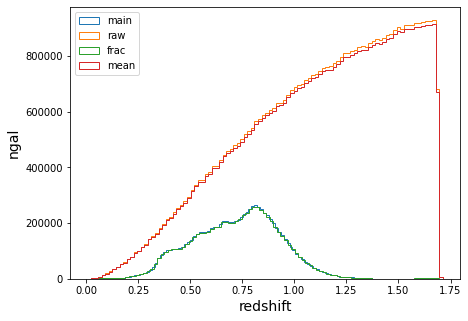

In [12]:
kw = dict(histtype='step', bins=100)
font = 14
fig = plt.gcf()
fig.set_size_inches(7, 5)

plt.hist(mock_main['Z'], label='main', **kw)
plt.hist(mock_raw['Z'], label='raw', **kw)
plt.hist(mock_cont_frac['Z'], label='frac', **kw)
plt.hist(mock_cont['Z'], label='mean', **kw)

plt.legend(loc='upper left')
plt.ylabel('ngal', fontsize=font)
plt.xlabel('redshift', fontsize=font)
fn = os.path.join(f'hist_frac.png')
#plt.savefig(fn, facecolor='white',bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()